In [41]:
!pip install pandas
!pip install numpy
!pip install plotly
!pip install --upgrade nbformat
!pip install scipy
!pip install category_encoders
!pip install matplotlib 
!pip install seaborn 

In [42]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as stats
from collections import Counter
import category_encoders as ce 
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split  
import re

## <center> 1. Загрузка данных </center>

In [43]:
data_train = pd.read_csv('data/hotels_train.csv')
data_test = pd.read_csv('data/hotels_test.csv')

Удалим дубликаты data_train

In [44]:
data_train = data_train.drop_duplicates()

Объединяем в единый DataFrame.

In [45]:
data_train['train'] = 1 
data_test['train'] = 0 
data_test['reviewer_score'] = 0 


data = pd.concat([data_train, data_test])
data.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,train
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,1
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,1


## <center> 2. Обработка данных </center>

#### 2.1 Очистка данных

Заполним пропуски в lat и lng вредним значением.

In [46]:
data['lat'] = data['lat'].fillna(data['lat'].mean())
data['lng'] = data['lng'].fillna(data['lng'].mean())
data.isnull().sum()

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
reviewer_score                                0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
train                                         0
dtype: int64

Пропуски отсутствуют.

In [47]:
data.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng,train
count,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.00000
mean,498.275079,8.397630,18.539760,2744.259084,17.777342,7.165215,6.296715,49.442788,2.824057,0.74985
std,500.618961,0.548033,29.690973,2317.823718,21.803204,11.038742,3.902967,3.456313,4.566185,0.43310
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,0.000000,41.328376,-0.369758,0.00000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,0.000000,48.214662,-0.143372,0.00000
50%,342.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,7.900000,51.499981,0.019886,1.00000
75%,660.000000,8.800000,23.000000,3633.000000,22.000000,8.000000,9.600000,51.516288,4.831098,1.00000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,10.000000,52.400181,16.429233,1.00000


В таблице выше не видно сильных выбросов. Но есть вероятность, что они есть

Прежде чем проверять числовые данные на выбросы, предлагаю проверить их на нормальность распределения чтобы понять применим ли к ним вообще метод Тьюки. 

In [48]:
# задаём уровень значимости
alpha = 0.05 

# Задаем перечень числовых параметров
num_list = ['average_score', 'review_total_negative_word_counts', 
         'total_number_of_reviews', 'review_total_positive_word_counts', 
         'total_number_of_reviews_reviewer_has_given', 'reviewer_score']

# проводим тест Шапиро — Уилка
for col in num_list:
    _, p= stats.shapiro(data[col])
    if p <= alpha:
        print(f'Распределение {col} не нормальное')
    else:
        print(f'Распределение {col} нормальное')



Распределение average_score не нормальное
Распределение review_total_negative_word_counts не нормальное
Распределение total_number_of_reviews не нормальное
Распределение review_total_positive_word_counts не нормальное
Распределение total_number_of_reviews_reviewer_has_given не нормальное
Распределение reviewer_score не нормальное


c:\Projects\DS\booking\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 515431.



Параметры не имеют нормального распределения. Нет смысла применять метод ТЬюки.

#### 2.2 Проектирование признаков

Посмотрим, что можно извлечь из столбца hotel_address.

In [49]:
print(data['hotel_address'][0],'/', data['hotel_address'][5000])

0    Stratton Street Mayfair Westminster Borough Lo...
0                   Via Senigallia 6 20161 Milan Italy
Name: hotel_address, dtype: object / 5000    Prinses Irenestraat 30 Zuideramstel 1077 WX Am...
5000      61 Quai De Grenelle 15th arr 75015 Paris France
Name: hotel_address, dtype: object


Последними словами идет страна. Попробуем ее извлечь.

In [50]:
print(data['hotel_address'].apply(lambda x: x.split()[-1]).unique())

['Kingdom' 'France' 'Netherlands' 'Italy' 'Austria' 'Spain']


In [51]:
data['hotel_country'] = data['hotel_address'].apply(lambda x: x.split()[-1] 
                                                    if x.split()[-1] != 'Kingdom' 
                                                    else x.split()[-2] + ' ' + x.split()[-1])

Обрабатываем значение и приводим перводим в категории и сбрасываем ненужный столбец.

In [52]:
data['hotel_country'] = data['hotel_country'].astype('category')
data = data.drop(['hotel_address'], axis=1)


additional_number_of_scoring оставляем без изменений. 

Рассмотрим review_date. Создадим признаки year, day_of_week, quarter.

In [53]:
data['review_date'] = pd.to_datetime(data['review_date'])
data['year'] = data['review_date'].dt.year
data['day_of_week'] = data['review_date'].dt.day_of_week
data['quarter'] = data['review_date'].dt.quarter


У нас уже есть столбец days_since_review. Мне кажется, что его использовать удобнее. сбрасываем review_date.

In [54]:
data = data.drop(['review_date'], axis=1)

In [55]:
data['days_since_review'] = \
data['days_since_review'].apply(lambda x: int(x.replace(' days', '').replace(' day', '')))

In [56]:
data.head(2)

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,train,hotel_country,year,day_of_week,quarter
0,581,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531,51.507894,-0.143671,1,United Kingdom,2016,4,1
1,299,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203,51.521009,-0.123097,1,United Kingdom,2017,3,1


Рассмотрим hotel_name.

In [57]:
print(data['hotel_name'][0],'/', data['hotel_name'][10000])

0    The May Fair Hotel
0        Hotel Da Vinci
Name: hotel_name, dtype: object / 10000        Holiday Inn London Regent s Park
10000    Appartement Hotel an der Riemergasse
Name: hotel_name, dtype: object


 предлагаю извлечь из него признаки royal, luxury, appart

In [58]:
data['royal'] = data['hotel_name'].apply(lambda x: 'royal' in x.lower())
data['luxury'] = data['hotel_name'].apply(lambda x: 'luxury' in x.lower())
data['appart'] = data['hotel_name'].apply(lambda x: 'appart' in x.lower())

Удаляем изначальный признак hotel_name

In [59]:
data = data.drop(['hotel_name'], axis=1)
data.head()

,additional_number_of_scoring,average_score,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,...,lat,lng,train,hotel_country,year,day_of_week,quarter,royal,luxury,appart
0,581,8.4,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,...,51.507894,-0.143671,1,United Kingdom,2016,4,1,False,False,False
1,299,8.3,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,...,51.521009,-0.123097,1,United Kingdom,2017,3,1,False,False,False
2,32,8.9,China,No kettle in room,6,406,No Positive,0,14,7.5,...,48.845377,2.325643,1,France,2016,1,4,False,False,False
3,34,7.5,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,...,48.888697,2.394540,1,France,2015,1,3,False,False,False
4,914,8.5,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,...,52.385601,4.847060,1,Netherlands,2016,5,1,False,False,False


Далее рассматриваем параметр reviewer_nationality.

In [60]:
data['reviewer_nationality'].unique()

array([' United Kingdom ', ' China ', ' Poland ', ' France ',
       ' Switzerland ', ' Bulgaria ', ' Lebanon ',
       ' United Arab Emirates ', ' South Africa ', ' Nigeria ',
       ' Sweden ', ' United States of America ', ' Hong Kong ',
       ' Luxembourg ', ' Netherlands ', ' Jersey ', ' Pakistan ',
       ' Mexico ', ' Italy ', ' Singapore ', ' Ireland ', ' Kuwait ',
       ' Bahrain ', ' Portugal ', ' Canada ', ' Germany ', ' Oman ',
       ' Austria ', ' Japan ', ' Ukraine ', ' Finland ', ' Iran ',
       ' Thailand ', ' Brazil ', ' Denmark ', ' Australia ', ' Spain ',
       ' Gabon ', ' New Zealand ', ' Israel ', ' Cyprus ', ' Gibraltar ',
       ' Turkey ', ' Egypt ', ' Indonesia ', ' Slovakia ', ' Qatar ',
       ' Romania ', ' Belgium ', ' Trinidad and Tobago ', ' ',
       ' Saudi Arabia ', ' Bhutan ', ' Iceland ', ' Norway ',
       ' Sri Lanka ', ' Isle of Man ', ' Greece ', ' Slovenia ',
       ' Serbia ', ' Czech Republic ', ' Hungary ', ' Latvia ',
       ' Estonia 

Врядли имеет смысл рассматривать все эти страны. Предлагаю Сократить до количества стран равного количеству стран hotel_country. 

Далее предлагаю одинаково закодировать оба признака и ввести признак совпадения hotel_country reviewer_nationality. Есть вероятность, что признак будет влиять на оценку отеля.

In [61]:
countries_dict = {'United Kingdom':1, 'France':2, 'Netherlands':3, 'Italy':4, 'Austria':5, 'Spain':6, 'other':7}

data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.strip())
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in countries_dict.keys() else 'other')
display(data['reviewer_nationality'].unique())


array(['United Kingdom', 'other', 'France', 'Netherlands', 'Italy',
       'Austria', 'Spain'], dtype=object)

In [62]:
# создаем объект OrdinalEncoder, col - имя столбца, mapping - словарь с описанием кодировки
ord_encoder = ce.OrdinalEncoder(mapping=[{
	'col': 'reviewer_nationality',
	'mapping': countries_dict
}])
# применяем трансформацию к столбцу reviewer_nationality
data_bin = ord_encoder.fit_transform(data['reviewer_nationality'])
# добавляем результат к исходному DataFrame
data['reviewer_nationality']=data_bin


ord_encoder = ce.OrdinalEncoder(mapping=[{
	'col': 'hotel_country',
	'mapping': countries_dict
}])
# применяем трансформацию к столбцу
data_bin = ord_encoder.fit_transform(data['hotel_country'])
# добавляем результат к исходному DataFrame
data['hotel_country']=data_bin


In [63]:
data['hotel_country_is_reviewer_nationality'] = data['reviewer_nationality'] == data['hotel_country']

In [64]:
data.head(3)

,additional_number_of_scoring,average_score,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,...,lng,train,hotel_country,year,day_of_week,quarter,royal,luxury,appart,hotel_country_is_reviewer_nationality
0,581,8.4,1,Leaving,3,1994,Staff were amazing,4,7,10.0,...,-0.143671,1,1,2016,4,1,False,False,False,True
1,299,8.3,1,poor breakfast,3,1361,location,2,14,6.3,...,-0.123097,1,1,2017,3,1,False,False,False,True
2,32,8.9,7,No kettle in room,6,406,No Positive,0,14,7.5,...,2.325643,1,2,2016,1,4,False,False,False,False


Рассмотрим negative_review. Его имеет смысл рассматривать вместе с positive_review.

In [65]:
print(len(data['negative_review'].unique()), len(data['positive_review'].unique()))

330011 412601


Одтинаковых отзывов слишком мало. Предлагаю извлечь из отзывов упоминание персонала и создать два признака: negative_stuff и positive_stuff.

In [66]:
data['negative_stuff'] = data['negative_review'].apply(lambda x: 1 if 'stuff' in x.lower() else 0)
data['positive_stuff'] = data['positive_review'].apply(lambda x: 1 if 'stuff' in x.lower() else 0)

In [67]:
display(data['negative_stuff'].sum(), data['positive_stuff'].sum())

np.int64(2450)

np.int64(3190)

не слишком много, но можно попробовать. Удаляем столбцы отзывов.

In [68]:
data = data.drop(['negative_review', 'positive_review'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 515431 entries, 0 to 128934
Data columns (total 23 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   reviewer_nationality                        515431 non-null  int64  
 3   review_total_negative_word_counts           515431 non-null  int64  
 4   total_number_of_reviews                     515431 non-null  int64  
 5   review_total_positive_word_counts           515431 non-null  int64  
 6   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 7   reviewer_score                              515431 non-null  float64
 8   tags                                        515431 non-null  object 
 9   days_since_review                           515431 non-null  int64  
 10  l

Остается рвссмотреть тольго столбец tags.

In [69]:
type(data['tags'].iloc[1])

str

In [70]:
tags = data['tags']
tag_count =[]
for tag in range(len(tags)):
    tag_count += data['tags'].iloc[tag].strip("[' ").strip(" ']").split(" ', ' ")
    
Counter(tag_count).most_common(10)

[('Leisure trip', 417538),
 ('Submitted from a mobile device', 307470),
 ('Couple', 252128),
 ('Stayed 1 night', 193568),
 ('Stayed 2 nights', 133850),
 ('Solo traveler', 108476),
 ('Stayed 3 nights', 95761),
 ('Business trip', 82884),
 ('Group', 65361),
 ('Family with young children', 60989)]

Предлагаю взять наиболее популярные 7 признаков и добавить соответствующие столбцы в таблицу (Признаик о пребывании обработаем по-другому). Также предлагаю добавить столбец stayed (пребывание).

In [71]:
tag_common = ['Leisure trip', 'Submitted from a mobile device', 
              'Couple', 'Solo traveler', 'Business trip', 'Group', 
              'Family with young children']

for tag in tag_common:
    data[tag] = data['tags'].apply(lambda x: tag in x)

Также предлагаю добавить столбец stayed (пребывание). Количество ночей.

In [72]:
stayed =[]
for tag in tag_count:
    if 'Stayed' in tag:
       stayed.append(tag)
       
set(stayed)

{'Stayed 1 night',
 'Stayed 10 nights',
 'Stayed 11 nights',
 'Stayed 12 nights',
 'Stayed 13 nights',
 'Stayed 14 nights',
 'Stayed 15 nights',
 'Stayed 16 nights',
 'Stayed 17 nights',
 'Stayed 18 nights',
 'Stayed 19 nights',
 'Stayed 2 nights',
 'Stayed 20 nights',
 'Stayed 21 nights',
 'Stayed 22 nights',
 'Stayed 23 nights',
 'Stayed 24 nights',
 'Stayed 25 nights',
 'Stayed 26 nights',
 'Stayed 27 nights',
 'Stayed 28 nights',
 'Stayed 29 nights',
 'Stayed 3 nights',
 'Stayed 30 nights',
 'Stayed 31 nights',
 'Stayed 4 nights',
 'Stayed 5 nights',
 'Stayed 6 nights',
 'Stayed 7 nights',
 'Stayed 8 nights',
 'Stayed 9 nights'}

In [73]:
def stayed_parse(x):
    x = x.replace('Stayed ', '')
    if x[1] ==' ':
        x = x[0]
    else:
        x = x[:2] 
    return int(x)

In [74]:
data['stayed'] = data['tags'].\
apply(lambda x: re.search(r'Stayed \d.', x).group() if re.search(r'Stayed \d.', x) else '00')
data['stayed'] = data['stayed'].apply(stayed_parse)

In [75]:
data['stayed'].unique()

array([ 2,  1,  3,  6,  4,  5,  8,  7, 10, 14, 19, 13,  9, 17, 11,  0, 27,
       12, 15, 21, 18, 16, 26, 24, 30, 22, 23, 28, 20, 25, 29, 31])

In [76]:
data = data.drop('tags', axis = 1) 

#### 2.3 Отбор признаков

In [77]:
fig = px.imshow(data.corr(numeric_only=True), 
                text_auto=True, aspect="auto",
                # width=40,
                # height=100
                )
fig.update_layout(width=1500, height=1500)
fig.show()

В соответствии с тепловой картой можем выделить следующие пары признаков с сильно й корреляцией:
1. *additional_number_of_scoring*  и total_number_of_reviews
2. lat и *hotel_country*
3. *reviewer_nationality* и hotel_country_is_reviewer_nationality
4. Leisure trip и *Business trip*
5. *days_since_review* и year

Предлагаю удалить признаки: total_number_of_reviews, lat, hotel_country_is_reviewer_nationality, Leisure trip, year

In [78]:
data = data.drop(['total_number_of_reviews', 'lat', 'hotel_country_is_reviewer_nationality', 'Leisure trip', 'year'], axis = 1) 

In [79]:
fig = px.imshow(data.corr(numeric_only=True), 
                text_auto=True, aspect="auto",
                # width=40,
                # height=100
                )
fig.update_layout(width=1500, height=1500)
fig.show()

Разобьем признаки на непрерывные и категориальные

In [80]:
# непрерывные признаки
num_cols = ['additional_number_of_scoring', 'average_score', 
            'review_total_negative_word_counts', 'review_total_positive_word_counts', 
            'total_number_of_reviews_reviewer_has_given', 
            'lng', 'stayed', 'days_since_review']

# категориальные признаки
cat_cols = ['reviewer_nationality', 'hotel_country', 'negative_stuff', 'positive_stuff', 
            'Submitted from a mobile device', 'Couple', 'Solo traveler', 'Business trip', 'Group', 
            'Family with young children', 'royal', 'luxury', 'appart', 'day_of_week', 'quarter']

In [81]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = data.drop(['reviewer_score'], axis = 1)  
y = data['reviewer_score'] 

Определим важность категориальных признаков.

<Axes: >

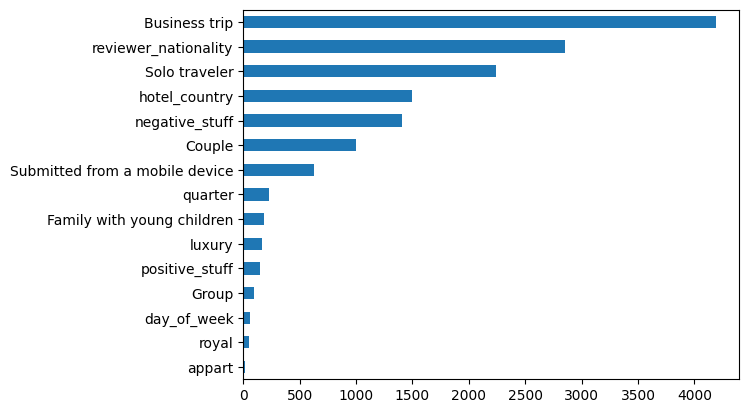

In [82]:
y=y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [83]:
data.columns

Index(['additional_number_of_scoring', 'average_score', 'reviewer_nationality',
       'review_total_negative_word_counts',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score',
       'days_since_review', 'lng', 'train', 'hotel_country', 'day_of_week',
       'quarter', 'royal', 'luxury', 'appart', 'negative_stuff',
       'positive_stuff', 'Submitted from a mobile device', 'Couple',
       'Solo traveler', 'Business trip', 'Group', 'Family with young children',
       'stayed'],
      dtype='object')

Столбцы к удалению:

In [84]:
cat_cols_to_delete = [
                      # 'day_of_week', 'appart', 'year',
                      ]

Определим важность непрерывных признаков.

<Axes: >

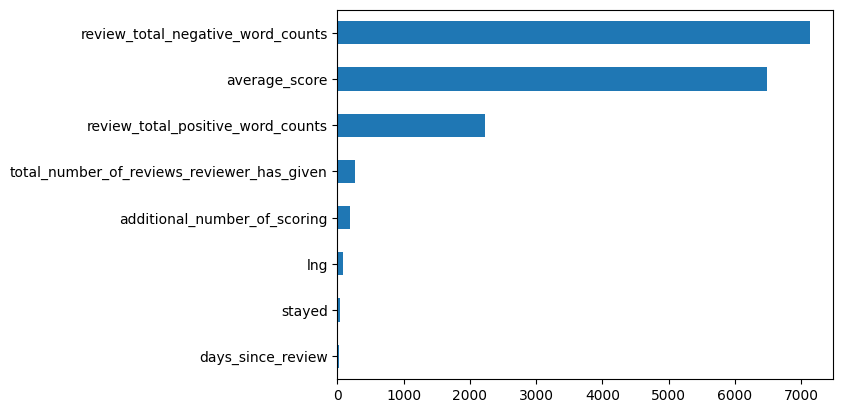

In [85]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Столбцы к удалению:

In [86]:
# num_cols_to_delete = ['stayed', 'days_since_review', 'lng', 'additional_number_of_scoring', 
#                       'total_number_of_reviews_reviewer_has_given']
num_cols_to_delete = [
                    #   'lng', 
                      ]

In [87]:
X = data.drop(num_cols_to_delete + cat_cols_to_delete, axis = 1)  

## <center> 3. Построение модели </center>

In [88]:
# Теперь выделим тестовую часть

data_train = X[data['train'] == 1].drop(['train'], axis=1)
data_test = X[data['train'] == 0].drop(['train'], axis=1)

y = data_train['reviewer_score'] 
X = data_train.drop(['reviewer_score'], axis=1)
data_test = data_test.drop(['reviewer_score'], axis=1)

In [89]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X, y)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(data_test)

In [90]:
to_competition = pd.DataFrame(y_pred)

In [91]:
y_test = pd.read_csv('data/submission.csv')

In [92]:
y_test['reviewer_score'] = y_pred

In [93]:
y_test.to_csv('data/to_competition.csv', index=False)